([<matplotlib.lines.Line2D at 0x7f2a9feaab10>],
 [<matplotlib.lines.Line2D at 0x7f2a9feaaed0>])

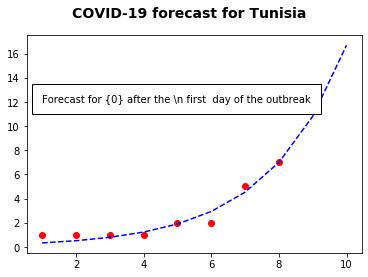

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt 
from scipy.optimize import curve_fit

data = pd.read_csv("../data/covid_19_data_12-Mar-2020/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")

def clean_data(dataframe, country):
    mydata = dataframe[dataframe['Country/Region'] == country].drop(columns=["Province/State", 
            "Country/Region", "Lat", "Long"]).reset_index(drop=True).T
    mydata.rename(columns={0:"cumulative_count"}, inplace=True)
    mydata["date"] = pd.to_datetime( mydata.index )
    mydata = mydata[mydata["cumulative_count"]!=0]
    mydata["days"] = np.linspace(1, len(mydata), len(mydata))
    mydata.reset_index(drop=True, inplace=True)   
    return mydata 

def SPG(t, r, m, A):
    """ """
    return (  ((r/m)*np.array(t)  ) +A )**m

def expgrowth(t, alpha, beta): 
    """ exponential growth"""
    return alpha*np.exp( np.array(t))**beta

def curve_fitting(dataframe): 
    days = dataframe.days
    cases_count = dataframe.cumulative_count
    parameters, pcov = curve_fit(expgrowth, days, cases_count)
    return parameters, pcov

def plot_exp_forecast(dataframne, popt, forecast_offset=10): 
    plot1 = plt.plot(dataframne.days, dataframne.cumulative_count,'o'  ,color ="red")
    offset_array = np.arange(list(Tunisia.days)[-1]+1, list(Tunisia.days)[-1]+forecast_offset+1  )
    offset = np.append(Tunisia.days, offset_array )
    #np.append(Tunisia.days)
    plot2 =  plt.plot(offset, expgrowth(offset, *popt),"--",color ="blue")
    return plot1, plot2




forecast = 5

fig = plt.figure()
fig.suptitle('COVID-19 forecast for Tunisia', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
ax.text(1, 12, r'Forecast for {0} after the \n first  day of the outbreak', 
        bbox={'facecolor': 'white',  'pad': 10})
popt, pcov = curve_fitting(Tunisia)
plot_exp_forecast(Tunisia, popt, 2)






,cumulative_count,date,days
0,1,2020-03-04,1.0
1,1,2020-03-05,2.0
2,1,2020-03-06,3.0
3,1,2020-03-07,4.0
4,2,2020-03-08,5.0
5,2,2020-03-09,6.0
6,5,2020-03-10,7.0
7,7,2020-03-11,8.0


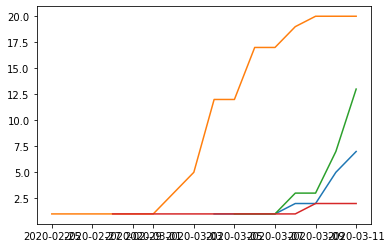

In [4]:
Italy = clean_data(data, "Italy")
Tunisia = clean_data(data, "Tunisia")
Algeria = clean_data(data, "Algeria")
SA = clean_data(data, "South Africa")
Egypt = clean_data(data, "Egypt")
Nigeria = clean_data(data, "Nigeria")
#plt.plot(Italy.date, Italy.cumulative_count )
plt.plot(Tunisia.date, Tunisia.cumulative_count )
plt.plot(Algeria.date, Algeria.cumulative_count )
plt.plot(SA.date, SA.cumulative_count)
#plt.plot(Egypt.date, Egypt.cumulative_count )
plt.plot(Nigeria.date, Nigeria.cumulative_count )

Tunisia

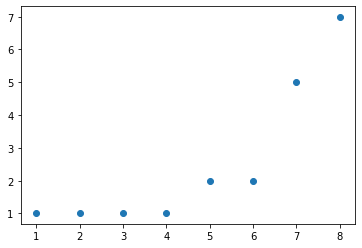

In [104]:
import numpy as np
subpd = Tunisia[Tunisia[75]!=0]

days =  np.linspace(start = 1, stop = len(subpd), num = len(subpd))  

plt.scatter(days, subpd[75])

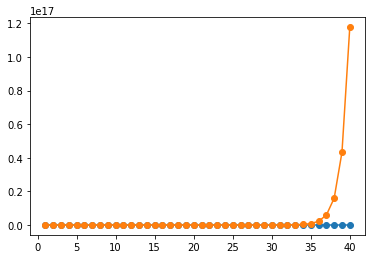

In [105]:
def SPG(t, r, m, A):
    return (  ((r/m)*np.array(t) ) +A )**m

def expgrowth(t, alpha, beta): 
    return alpha*np.exp( np.array(t))**beta

time = np.linspace(start = 1, stop = 40, num = 40)
sim_data = SPG(time, 8, 8, 8)

plt.plot(time, SPG(time, 10, 5, 1) , "-o" )
plt.plot(time, expgrowth(time, 0.5, 1), "-o" )


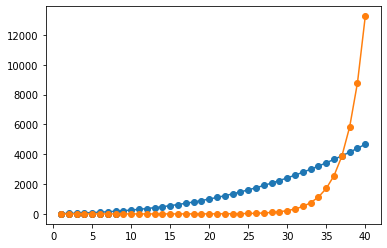

In [107]:
plt.plot(days, subpd[75],'o'  ,color ="black")
plt.plot(time, SPG(time, r=1.5, m=2.6, A=2.7), "-o" )
plt.plot(time, expgrowth(time, alpha=0.001, beta=0.41), "-o" )


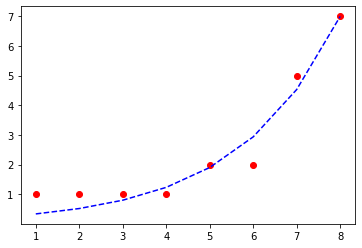

In [112]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(expgrowth, days, subpd[75])
plt.plot(days, subpd[75],'o'  ,color ="red")
plt.plot(days, expgrowth(days, *popt),"--",color ="blue")



In [114]:
np.linspace(1, 20, 20)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.])

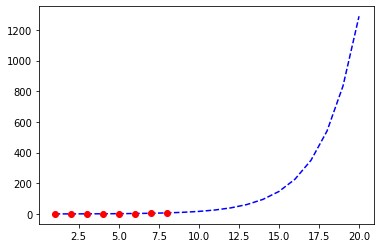

In [125]:
plt.plot(np.linspace(1, 20, 20), expgrowth(np.linspace(1, 20, 20), *popt),"--",color ="blue")

plt.plot(days, subpd[75],'o'  ,color ="red")
